In [1]:
# 패키지 로딩하기
import re
import numpy as np
import tensorflow as tf
import os
import glob
import sklearn.model_selection
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
txt_file_path = os.getenv("HOME") + "/aiffel/lyricist/data/lyrics/*" # ~/aiffel/lyricist/data/lyrics 폴더 안의 모든 파일 선택
txt_list      = glob.glob(txt_file_path)                             # 파일 경로 안의 모든 파일 이름 리스트형태로 반환

In [3]:
raw_corpus = []                     # 미리 빈 리스트를 만들고

for txt_file in txt_list:           # txt_list을 하나씩 가져와서 txt_file이라고 명명하고
    with open(txt_file, "r") as f:  # txt_file을 읽기전용으로 열고 f라고 명명하고
        raw = f.read().splitlines() # f을 한줄씩 읽어와서
        raw_corpus.extend(raw)      # 미리 만들어 놓은 raw_corpus에 넣는다. (iterable로 넣기위해 extend 사용)

In [4]:
print("전체 문장 갯수 :", len(raw_corpus))
print("예시 문장 5개 :", raw_corpus[:5])

# 연극 대사처럼 따로 빼거나 없애야 하는 특수문자는 보이지 않음

전체 문장 갯수 : 187088
예시 문장 5개 : ['The first words that come out', 'And I can see this song will be about you', "I can't believe that I can breathe without you", 'But all I need to do is carry on', 'The next line I write down']


In [5]:
# 데이터 정제하기 (데이터 전처리)
# 토큰화 했을 때 토큰 갯수가 15개를 넘어가는 문장은 학습데이터에서 제외함. (노드에서 시킴)
def preprocess_sentence(sentence):      # 문장을 정제하는 함수를 만들 것임
    sentence = sentence.lower().strip() # 먼저 들어온 문장을 소문자로 바꾸고 양쪽 공백이 있으면 제거함
    
    # 문장에서 처리해줘야 할 기호나 패턴을 처리
    # 실습 데이터는 그대로 써도 될 것같지만 혹시 몰라서 노드에 있는 경우의 수를 그대로 씀
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)   # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)          # 공백 패턴을 만나면 공백 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 알파벳(대,소문자), ?.!,¿패턴을 제외한 모든 문자(공백 포함)를 공백 1개로 치환
    
    sentence = sentence.strip()                          # 한번 더 양쪽 공백 제거
    sentence = "<start> " + sentence + " <end>"          # sentence 양쪽에 시작과 끝을 알리는 단어를 붙여줌
    
    return sentence

In [6]:
# 함수가 잘 만들어졌는지 확인하기
print(preprocess_sentence("Test : It's @#%^$#%$ sample     text"))

# 공백, 특수문자 전부 잘 처리됨.

<start> test it s sample text <end>


In [7]:
corpus = [] # 빈 리스트를 미리 만들고

for sentence in raw_corpus:                       # 기존의 텍스트 데이터를 한개씩 가져와서
    if len(sentence) == 0: continue               # 아무것도 없는 것은 제외하고
    temp_sentence = preprocess_sentence(sentence) # 정제하는 함수를 거친 뒤
    if len(temp_sentence.split()) > 15: continue  # 토큰의 갯수가 15개를 넘어가는 문장은 데이터에서 제외하고
    corpus.append(temp_sentence)                  # 리스트에 추가한다.

corpus[:9] # 잘 뽑혔는지 10개만 출력하여 확인하기

# 잘 작동함.

['<start> the first words that come out <end>',
 '<start> and i can see this song will be about you <end>',
 '<start> i can t believe that i can breathe without you <end>',
 '<start> but all i need to do is carry on <end>',
 '<start> the next line i write down <end>',
 '<start> and there s a tear that falls between the pages <end>',
 '<start> i know that pain s supposed to heal in stages <end>',
 '<start> i could throw it in the river and watch it sink in slowly <end>',
 '<start> tie the pages to a plane and send it to the moon <end>']

In [8]:
print("corpus 갯수 :", len(corpus)) 

corpus 갯수 : 156227


In [9]:
# 정제한 데이터를 텐서(벡터화)로 만들기
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 12000,   # 전체 단어의 개수 - 하이퍼파라미터
                                                      filters   = " ",     # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
                                                      oov_token = "<unk>") # 사전에 없었던 단어는 어떤 토큰으로 대체할지 정한다.
    tokenizer.fit_on_texts(corpus) # corpus로부터 tokenizer가 사전을 자동 구축한다.
    
    tensor = tokenizer.texts_to_sequences(corpus) # 구축한 사전으로부터 corpus를 해석해 tensor로 변환한다.
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공한다. 
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = "post")
    
    return tensor, tokenizer

In [10]:
tensor, tokenizer = tokenize(corpus) # 전처리를 한 데이터를 만든 함수에 적용시켜서 텐서로 만든다.
print(tensor.shape)                  # 156227개의 문장이 있고, 문장의 토큰 최대길이는 15이다.

(156227, 15)


In [11]:
print(tensor[:5, ])

[[  2   6 247 434  15  68  57   3   0   0   0   0   0   0   0]
 [  2   8   4  35  63  41 357  84  27 112   7   3   0   0   0]
 [  2   4  35  16 218  15   4  35 768 257   7   3   0   0   0]
 [  2  33  25   4  92  10  48  26 832  18   3   0   0   0   0]
 [  2   6 330 442   4 760  58   3   0   0   0   0   0   0   0]]


In [12]:
# 평가 데이터셋 분리
source_input = tensor[:, :-1] # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
target_input = tensor[:, 1:]  # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(source_input[0])
print(target_input[0])

[  2   6 247 434  15  68  57   3   0   0   0   0   0   0]
[  6 247 434  15  68  57   3   0   0   0   0   0   0   0]


In [13]:
# sklear를 이용하여 train data와 vaildation data로 나눈다.
enc_train, enc_val, dec_train, dec_val = sklearn.model_selection.train_test_split(source_input, target_input, test_size = 0.2)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)


In [14]:
buffer_size     = len(source_input)
batch_size      = 256
steps_per_epoch = buffer_size // batch_size

vocab_size = tokenizer.num_words + 1 # tokenizer가 구축한 단어사전 내 12000개 + 여기에 포함되지 않은 0 : <pad>를 포함하여 12001개

dataset = tf.data.Dataset.from_tensor_slices((source_input, target_input)).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder = False)
dataset

<BatchDataset shapes: ((None, 14), (None, 14)), types: (tf.int32, tf.int32)>

In [15]:
training_set = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(buffer_size)
training_set = training_set.batch(batch_size, drop_remainder = False)
training_set

<BatchDataset shapes: ((None, 14), (None, 14)), types: (tf.int32, tf.int32)>

In [16]:
vaildation_set = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(buffer_size)
vaildation_set = vaildation_set.batch(batch_size, drop_remainder = False)
vaildation_set

<BatchDataset shapes: ((None, 14), (None, 14)), types: (tf.int32, tf.int32)>

In [17]:
# 모델 만들기
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1     = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.rnn_2     = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.linear    = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [18]:
model = TextGenerator(vocab_size = vocab_size, embedding_size = 2048, hidden_size = 4096) # embedding_size와 hidden_size를 조절하여 원하는 결과를 도출하자

In [19]:
# model을 bilud하기 위해 하나의 데이터를 넣는다
for source_sample, target_sample in dataset.take(1): break
model(source_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-3.25078436e-05, -4.41519689e-04,  2.22233357e-04, ...,
         -3.67289118e-04,  2.38302018e-04, -5.10258309e-04],
        [-2.70841207e-04, -9.28984955e-04,  8.97932405e-05, ...,
         -3.58201534e-04,  1.74190645e-04, -7.73179985e-04],
        [-2.25546773e-05, -1.11772027e-03, -2.43842715e-05, ...,
         -4.92072024e-04,  3.78538622e-04, -7.69744744e-04],
        ...,
        [ 6.66342583e-03, -5.56363200e-04,  1.46071822e-03, ...,
          3.08160577e-03,  8.34484308e-05,  4.75536217e-04],
        [ 7.85731617e-03, -3.25500441e-04,  1.05753576e-03, ...,
          3.13941226e-03,  5.17492299e-04,  4.95407032e-04],
        [ 8.88447836e-03, -1.87304293e-04,  5.73161757e-04, ...,
          3.07200896e-03,  7.47320883e-04,  5.25766984e-04]],

       [[-3.25078436e-05, -4.41519689e-04,  2.22233357e-04, ...,
         -3.67289118e-04,  2.38302018e-04, -5.10258309e-04],
        [ 2.57896696e-04, -9.65029816e-04,  2

In [20]:
model.summary() # 모델 구조 보기

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  24578048  
_________________________________________________________________
lstm (LSTM)                  multiple                  100679680 
_________________________________________________________________
lstm_1 (LSTM)                multiple                  134234112 
_________________________________________________________________
dense (Dense)                multiple                  49168097  
Total params: 308,659,937
Trainable params: 308,659,937
Non-trainable params: 0
_________________________________________________________________


In [21]:
optimizer = tf.keras.optimizers.Adam()
loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = "none")

model.compile(loss = loss, optimizer = optimizer, metrics = ["accuracy"])        # model을 compile하고
history = model.fit(training_set, epochs = 10, validation_data = vaildation_set) # 훈련시킨 후 그 결과를 history에 저장한다.

Epoch 1/10
489/489 [==============================] - 698s 1s/step - loss: 3.2404 - accuracy: 0.5080 - val_loss: 2.8842 - val_accuracy: 0.5314
Epoch 2/10
489/489 [==============================] - 697s 1s/step - loss: 2.6965 - accuracy: 0.5450 - val_loss: 2.6382 - val_accuracy: 0.5534
Epoch 3/10
489/489 [==============================] - 695s 1s/step - loss: 2.3862 - accuracy: 0.5730 - val_loss: 2.4693 - val_accuracy: 0.5764
Epoch 4/10
489/489 [==============================] - 692s 1s/step - loss: 2.0846 - accuracy: 0.6074 - val_loss: 2.3342 - val_accuracy: 0.5990
Epoch 5/10
489/489 [==============================] - 674s 1s/step - loss: 1.7882 - accuracy: 0.6510 - val_loss: 2.2317 - val_accuracy: 0.6225
Epoch 6/10
489/489 [==============================] - 671s 1s/step - loss: 1.5137 - accuracy: 0.6997 - val_loss: 2.1601 - val_accuracy: 0.6435
Epoch 7/10
489/489 [==============================] - 673s 1s/step - loss: 1.2839 - accuracy: 0.7454 - val_loss: 2.1369 - val_accuracy: 0.6590

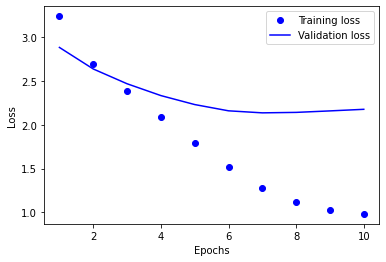

In [22]:
# Loss 그래프 시각화
train_accuracy = history.history["accuracy"]
val_accuracy   = history.history["val_accuracy"]
train_loss     = history.history["loss"]
val_loss       = history.history["val_loss"]

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_loss, "bo", label = "Training loss")   # train_loss는 파란색 점 표시
plt.plot(epochs, val_loss,   "b",  label = "Validation loss") # val loss는 파란색 실선 표시
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
def generate_text(model, tokenizer, init_sentence = "<start>", max_len = 20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input  = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token   = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict      = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [24]:
# model 테스트 : "i love"란 문장을 주고 20문장이 넘지 않는 문장을 만들게 하기
generate_text(model, tokenizer, init_sentence = "<start> i love", max_len = 20)

'<start> i love you so much <end> '